In [2]:
import yaml
import os
import pandas as pd
from boto3.session import Session
import cv2
import numpy as np
import ipyvolume as ipv
import joblib # joblib version: 0.9.4
import pickle
#from tqdm.notebook import tqdm



# os.listdir(config['dataset']['path'])


In [3]:
%%javascript 

IPython.OutputArea.prototype._should_scroll = function(lines) { 
    return false; } 

<IPython.core.display.Javascript object>

In [24]:
# config = '../script/config.yml'
# with open (config , 'rb') as f:
#     config = yaml.load(f ,Loader=yaml.FullLoader)
    
# config

In [ ]:
# config = '../script/config.yml'
# config = '../script/configs/download/config_flowing.yml'
config = '../script/configs/download/config_stall.yml'


with open (config , 'rb') as f:
    config = yaml.load(f ,Loader=yaml.FullLoader)
    




class ClogLossDataset_downloader:
    def __init__(self, config , online_data= True , draw_3d = False  ):
        self.cfg = config
        self.dataPath = config['dataset']['path']
        self.videoPath = os.path.join(config['dataset']['path'], 'video')
        self.online_data = online_data
        self.remove = config['dataset']['remove_donloaded_video']
        self.draw_3d = draw_3d
        self.saveDatasetDir  = config['dataset']['save_dir']
        
        if not os.path.exists(self.saveDatasetDir):
            os.makedirs(self.saveDatasetDir)
        
        metaData = os.path.join(self.dataPath ,'train_metadata.csv')
        metaData = pd.read_csv(metaData)
        
        label = os.path.join(self.dataPath ,'train_labels.csv')
        label = pd.read_csv(label)
        
        self.df_dataset = metaData
        self.df_dataset['stalled'] =label['stalled']
        
#         self.df_dataset = metaData[metaData['filename'].isin(df['filename'])]
#         self.df_dataset['stalled'] =label[label['filename'].isin(df['filename'])]['stalled']
        self.df_dataset['vid_id'] = self.df_dataset.index
    
        with open(os.path.join(config['dataset']['path'],'whole_train_dataset.pandas'),'wb') as handel:
            pickle.dump(self.df_dataset , handel ,protocol=pickle.HIGHEST_PROTOCOL)
            
    
    
    
    
    
    
        
        
        
        if online_data:
            self.download_fldr = 'downloded_data' 
            self.download_fldr = os.path.join(self.dataPath ,self.download_fldr )
            if not os.path.exists(f"./{self.download_fldr}"):
                os.mkdir(self.saveDatasetDir)
            credentials_path = config['dataset']['credentials_path']
            with open (credentials_path , 'rb') as f:
                credentials = yaml.load(f ,Loader=yaml.FullLoader)
#                 print(credentials)

            ACCESS_KEY = credentials['ACCESS_KEY']
            SECRET_KEY = credentials['SECRET_KEY']

            session = Session(aws_access_key_id=ACCESS_KEY,
                          aws_secret_access_key=SECRET_KEY)
            s3 = session.resource('s3')
            self.bucket = s3.Bucket('drivendata-competition-clog-loss')
#             self.df_dataset = self.df_dataset[self.df_dataset['num_frames'] > 200]
#             train_Dataset.df_dataset[train_Dataset.df_dataset['tier1']== True]
            
#             self.df_dataset = self.df_dataset[self.df_dataset['stalled']==0]

#             for s3_file in your_bucket.objects.all():
#                 print(s3_file.key) # prints the contents of bucket
                
        else:
            df = pd.DataFrame([file for file in os.listdir(self.videoPath)  if file.split('.')[-1] == 'mp4'], columns=['filename'])
            self.df_dataset = self.df_dataset[metaData['filename'].isin(df['filename'])]
            self.df_dataset = self.df_dataset.reset_index(drop = True)
            
        # filter dataset
        self.filter_dataset()
        # limit_data
        lim_min = self.cfg['dataset']['filter']['limit']['min']
        lim_max = self.cfg['dataset']['filter']['limit']['max']
        lim_flag = self.cfg['dataset']['filter']['limit']['flag']
        if lim_flag:
            self.df_dataset = self.df_dataset.iloc[lim_min :lim_max]
            
        with open(os.path.join(self.saveDatasetDir, f"{os.path.basename(self.saveDatasetDir)}.pandas"),'wb') as handel:
            pickle.dump(self.df_dataset , handel ,protocol=pickle.HIGHEST_PROTOCOL)
            
        self.number_of_objec = len(self.df_dataset)
        self.current_row=0
        
        
        
    def filter_dataset(self):
        filter_dict={}
        
        def apply_filter_each_row(row, filter_vector, col_name):
                return [True ,False][row[col_name] in filter_vector]
            
            
        
        try:
            filter_dict["tier1"] = self.cfg['dataset']['filter']['tier1']
        except:
            pass
        
        try:
            filter_dict["project_id"] = self.cfg['dataset']['filter']['project_id']
        except:
            pass
        
        try:
            filter_dict["stalled"] = self.cfg['dataset']['filter']['stalled']
        except:
            pass
        
        try:
            filter_dict["num_frames"] = self.cfg['dataset']['filter']['num_frames']
        except:
            pass
        
        try:
            filter_dict["crowd_score"] = self.cfg['dataset']['filter']['crowd_score']
        except:
            pass
        
        print(filter_dict)
        
        for key_ , filter_vec in filter_dict.items():
            
            if key_ in ['num_frames' ,'crowd_score']:
#                 print("--------------->",filter_vec , filter_vec[0])
                # filter more than max value
                filter_ = (self.df_dataset[self.df_dataset[key_] < filter_vec[0]].index.to_list()) 
                self.df_dataset = self.df_dataset.drop(filter_).reset_index(drop=True)
                
                # filter less than min value
                filter_ = self.df_dataset[self.df_dataset[key_] > filter_vec[1]].index.to_list()
                self.df_dataset = self.df_dataset.drop(filter_).reset_index(drop=True)

                
            else:
            
                filtred_indexex = self.df_dataset.apply(lambda row: apply_filter_each_row(row, filter_vec, key_),
                                                               axis=1)

                outliers = self.df_dataset[filtred_indexex].index.to_list()
                self.df_dataset = self.df_dataset.drop(outliers).reset_index(drop=True)
            
            

        
    
        
        
        
    def getFrame( self , vidcap , sec , image_name ):
        vidcap.set(cv2.CAP_PROP_POS_MSEC, sec * 1000)
        hasFrames,image = vidcap.read()
        if(hasFrames):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image ,hasFrames
    
    def get_specified_area(self , image):
    
        # convert to hsv to detect the outlined orange area
        hsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
        lower_red = np.array([100,120,150])
        upper_red = np.array([110,255,255])
        # create a mask
        mask1 = cv2.inRange(hsv, lower_red, upper_red)
        mask1 = cv2.dilate(mask1, None, iterations=2)
        mask_ind = np.where(mask1>0)
        xmin , xmax = min(mask_ind[1]) , max(mask_ind[1])
        ymin , ymax = min(mask_ind[0]) , max(mask_ind[0])
        # remove orange line from the image
        return mask1 ,(xmin , xmax , ymin , ymax)
    
    
    def filter_image(self, image ,mask1 ,area):
        xmin , xmax,ymin , ymax = area
        
        mask_ind = np.where(mask1>0)
        image[mask_ind ]=0,0,0
        # fill the area to skip the data outside of this area
        ret,mask1 = cv2.threshold(mask1,10,255,cv2.THRESH_BINARY_INV)
        contours,hierarchy = cv2.findContours(mask1, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        contours = [ctr for ctr in contours if cv2.contourArea(ctr) < 5*(mask1.shape[0]*mask1.shape[1])/6]
        contours = sorted(contours, key=cv2.contourArea, reverse=True)
#         print(len(contours))
        cv2.drawContours(mask1, [contours[-1]], -1, (0, 0, 0), -1)
        # remove data out of the outlined area
        image[mask1>0] = (0,0,0)
        
    #     image =  cv2.rectangle(image , (xmin,ymin) ,(xmax,ymax),(255,255,255),4,4)
        image = image[ ymin:ymax , xmin:xmax ]
        image = cv2.resize(image ,(150,150))
        
#         image = image /255.
    #     image -= image.mean()
    #     image /= image.std()
    #     print(image.shape , xmin , xmax,ymin , ymax)
        return image
    
    @staticmethod
    def draw_tensor(tensor_img):

        ipv.figure()
#         ipv.volshow(tensor_img[...,0], level=[0.36, 0.55,1], opacity=[0.11,0.13, 0.13], level_width=0.05, data_min=0, data_max=1 ,lighting=True)
        ipv.volshow(tensor_img[...,0], level=[0.36, 0.17,0.36], opacity=[0.05,0.13, 0.10], level_width=0.05, data_min=0, data_max=1 ,lighting=True)
        
        ipv.view(-30, 45)
        ipv.show()
        
    def create_metadata(self,row):
        meta_data = {}
        meta_data['filename'] = row.filename
        meta_data['crowd_score'] = row.crowd_score
        meta_data['tier1'] = row.tier1
        meta_data['stalled'] = row.stalled
        meta_data['vid_id'] = row.vid_id
        meta_data['project_id'] = row.project_id
        meta_data['num_frames'] = row.num_frames
        return meta_data
    
    def __len__(self):
        return len(self.df_dataset)-1
        
        
    def __getitem__(self, index):
        row = self.df_dataset.iloc[index]
        
        metadata = self.create_metadata(row)
        
        if self.online_data:
            vid_p = os.path.join(self.download_fldr ,f"{row.filename}")
            self.bucket.download_file(f"train/{row.filename}",vid_p )       
            vidcap = cv2.VideoCapture(vid_p)
#             
        else:
            vidcap = cv2.VideoCapture(os.path.join(self.videoPath,row.filename))
        total_frames = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
#         total_frames = config['dataset']['num_frames']
        frame_size = (int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH)) , int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT )))
        fps = vidcap.get(cv2.CAP_PROP_FPS)
        Video_len = total_frames / fps
        from_sec = 0 
        time_stamp = np.linspace(from_sec , Video_len , int(total_frames / 1.0) )
    
        tensor_img = []
        
        for frame in range(int(total_frames)):
            image , hasframe = self.getFrame(vidcap ,time_stamp[frame] , frame)
            
            if hasframe:
                if frame==0:
                    mask , area = self.get_specified_area(image)
                image = self.filter_image(image , mask, area)
                tensor_img.append(image)
                
            # if frame >= 199:
                # break
            
            
        # if  len(tensor_img) < 200:
            # for kk in range(200 - len(tensor_img) ):
                # tensor_img.append(list(np.zeros([150,150,3])))
                
#         print(len(tensor_img))
        vidcap.release()  
        if self.remove:
            os.remove(vid_p)
        tensor_img = np.array(list(tensor_img))
#         print(tensor_img.shape)
        if self.draw_3d :
            self.draw_tensor(tensor_img)
#         print(row)
#         tensor_img = np.moveaxis(tensor_img,3,0)
        tensor_img = tensor_img.astype(np.uint8)
        joblib.dump([tensor_img , metadata], os.path.join(self.saveDatasetDir ,f"{row.filename.split('.')[0]}.lzma"), compress=('lzma', 6))
#         print(os.path.join(self.saveDatasetDir ,f"{row.filename}"))
        
        return [tensor_img , metadata]
    
video_downloder = ClogLossDataset_downloader(config ,draw_3d=True )

{'tier1': [True], 'project_id': ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'M'], 'stalled': [1], 'crowd_score': [0.7, 1.0]}


In [ ]:
print(len(video_downloder))

In [8]:
_,_ =video_downloder[0]
_

C:\Users\alibh\Anaconda3\envs\py37\lib\site-packages\ipyvolume\serialize.py:81: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0]**2 + gradient[1]**2 + gradient[2]**2)


{'filename': '100289.mp4',
 'crowd_score': 0.765824,
 'tier1': True,
 'stalled': 1,
 'vid_id': 280,
 'project_id': 'G',
 'num_frames': 59}

In [64]:
# for i in tqdm(range(len(video_downloder))):
#     video_downloder[i]
    

In [11]:
# video_downloder[573047]

In [18]:
video_downloder.df_dataset.groupby(['project_id']).first()

,filename,url,num_frames,crowd_score,tier1,micro,nano,stalled,vid_id
project_id,,,,,,,,,
A,103580.mp4,s3://drivendata-competition-clog-loss/train/10...,47,0.722303,False,False,False,1,3481
C,103390.mp4,s3://drivendata-competition-clog-loss/train/10...,63,0.814702,True,True,True,1,3297
D,149368.mp4,s3://drivendata-competition-clog-loss/train/14...,36,1.000000,True,True,True,1,48173
E,149497.mp4,s3://drivendata-competition-clog-loss/train/14...,73,0.775940,True,True,True,1,48300
F,104630.mp4,s3://drivendata-competition-clog-loss/train/10...,98,0.705105,False,False,False,1,4497
G,100289.mp4,s3://drivendata-competition-clog-loss/train/10...,59,0.765824,True,True,True,1,280
H,105028.mp4,s3://drivendata-competition-clog-loss/train/10...,60,1.000000,True,True,True,1,4886
I,102230.mp4,s3://drivendata-competition-clog-loss/train/10...,46,0.702758,False,False,False,1,2168
J,184523.mp4,s3://drivendata-competition-clog-loss/train/18...,56,0.786592,True,True,True,1,82470


In [77]:
video_downloder.df_dataset

,filename,url,project_id,num_frames,crowd_score,tier1,micro,nano,stalled,vid_id
0,100109.mp4,s3://drivendata-competition-clog-loss/train/10...,L,67,0.000000,True,True,True,1,107
1,100289.mp4,s3://drivendata-competition-clog-loss/train/10...,G,59,0.765824,True,True,True,1,280
2,102952.mp4,s3://drivendata-competition-clog-loss/train/10...,G,54,1.000000,True,True,True,1,2871
3,103390.mp4,s3://drivendata-competition-clog-loss/train/10...,C,63,0.814702,True,True,True,1,3297
4,104360.mp4,s3://drivendata-competition-clog-loss/train/10...,I,94,0.914924,True,True,True,1,4234
...,...,...,...,...,...,...,...,...,...,...
701,683269.mp4,s3://drivendata-competition-clog-loss/train/68...,I,47,0.774181,True,True,True,1,569214
702,683724.mp4,s3://drivendata-competition-clog-loss/train/68...,G,46,1.000000,True,True,True,1,569654
703,684132.mp4,s3://drivendata-competition-clog-loss/train/68...,K,75,0.894249,True,True,True,1,570048
704,684243.mp4,s3://drivendata-competition-clog-loss/train/68...,F,55,0.764303,True,True,True,1,570156


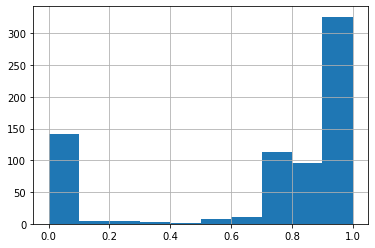

In [66]:
video_downloder.df_dataset['crowd_score'].hist()

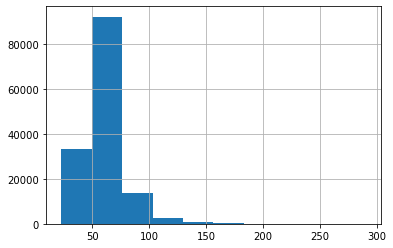

In [79]:
video_downloder.df_dataset[video_downloder.df_dataset['tier1'] == True]
video_downloder.df_dataset[video_downloder.df_dataset['project_id'] == 'A']['num_frames'].hist()

In [63]:
video_downloder.df_dataset[  video_downloder.df_dataset['crowd_score'] > 0.7]


video_downloder.df_dataset[  ((video_downloder.df_dataset['crowd_score'] > .7)\
#                             & (video_downloder.df_dataset['crowd_score'] > .50)\
                            & (video_downloder.df_dataset['stalled'] ==1))]
# # video_downloder.df_dataset.groupby(['project_id']).apply(list)


,filename,url,project_id,num_frames,crowd_score,tier1,micro,nano,stalled,vid_id
280,100289.mp4,s3://drivendata-competition-clog-loss/train/10...,G,59,0.765824,True,True,True,1,280
2168,102230.mp4,s3://drivendata-competition-clog-loss/train/10...,I,46,0.702758,False,False,False,1,2168
2871,102952.mp4,s3://drivendata-competition-clog-loss/train/10...,G,54,1.000000,True,True,True,1,2871
3297,103390.mp4,s3://drivendata-competition-clog-loss/train/10...,C,63,0.814702,True,True,True,1,3297
3481,103580.mp4,s3://drivendata-competition-clog-loss/train/10...,A,47,0.722303,False,False,False,1,3481
...,...,...,...,...,...,...,...,...,...,...
569214,683269.mp4,s3://drivendata-competition-clog-loss/train/68...,I,47,0.774181,True,True,True,1,569214
569654,683724.mp4,s3://drivendata-competition-clog-loss/train/68...,G,46,1.000000,True,True,True,1,569654
570048,684132.mp4,s3://drivendata-competition-clog-loss/train/68...,K,75,0.894249,True,True,True,1,570048
570156,684243.mp4,s3://drivendata-competition-clog-loss/train/68...,F,55,0.764303,True,True,True,1,570156


In [ ]:
# joblib.load('../../data/generated_Tensors/100010.lzma')

In [ ]:
# import cv2
# import numpy as np


# def getFrame(  vidcap , sec , image_name ):
#     vidcap.set(cv2.CAP_PROP_POS_MSEC, sec * 1000)
#     hasFrames,image = vidcap.read()
#     if(hasFrames):
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     return image ,hasFrames


# vidcap = cv2.VideoCapture('./test2.avi')
# total_frames = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
# #         total_frames = config['dataset']['num_frames']
# frame_size = (int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH)) , int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT )))
# fps = vidcap.get(cv2.CAP_PROP_FPS)
# Video_len = total_frames / fps
# from_sec = 0 
# time_stamp = np.linspace(from_sec , Video_len , int(total_frames+1 / 1.0) )

# tensor_img = []

# for frame in range(int(total_frames)):
#     image , hasframe = getFrame(vidcap ,time_stamp[frame] , frame)

#     if hasframe:
#         tensor_img.append(image)
        
# b = np.array(tensor_img).shape

In [ ]:
# class Counter:
#     def __init__(self, low, high):
#         self.current = low - 1
#         self.high = high

#     def __iter__(self):
#         return self

#     def __next__(self): # Python 2: def next(self)
#         self.current += 1
#         if self.current < self.high:
#             return self.current
#         raise StopIteration


# for c in Counter(3, 9):
#     print(c)